# **Telecom Customer Churn Prediction**

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA

Load the data file & look at the top 5 records of data

In [75]:
customer_data = pd.read_csv("customer_data.csv")
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Check the various attributes of data like shape (rows and columns), columns

In [76]:
customer_data.shape

(7043, 21)

In [77]:
customer_data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [78]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Check the descriptive statistics of numeric variables

In [79]:
customer_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Plot a horizontal bar chart showing the count of each category in the 'Churn' column

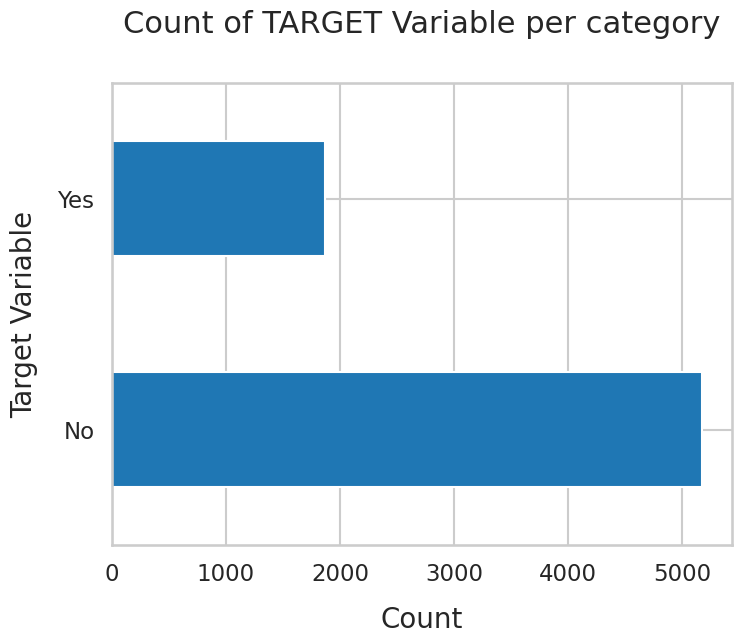

In [80]:
customer_data['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [81]:
100*customer_data['Churn'].value_counts()/len(customer_data['Churn'])

,count
Churn,
No,73.463013
Yes,26.536987




Here, we can see that the data is highly imbalanced, ratio: 73:27.




In [82]:
customer_data.Churn[customer_data.Churn == "No"].groupby(by = customer_data.gender).count()

,Churn
gender,
Female,2549
Male,2625


In [83]:
customer_data.Churn[customer_data.Churn == "Yes"].groupby(by = customer_data.gender).count()

,Churn
gender,
Female,939
Male,930


Visualize the missing data using a matrix plot

<Axes: >

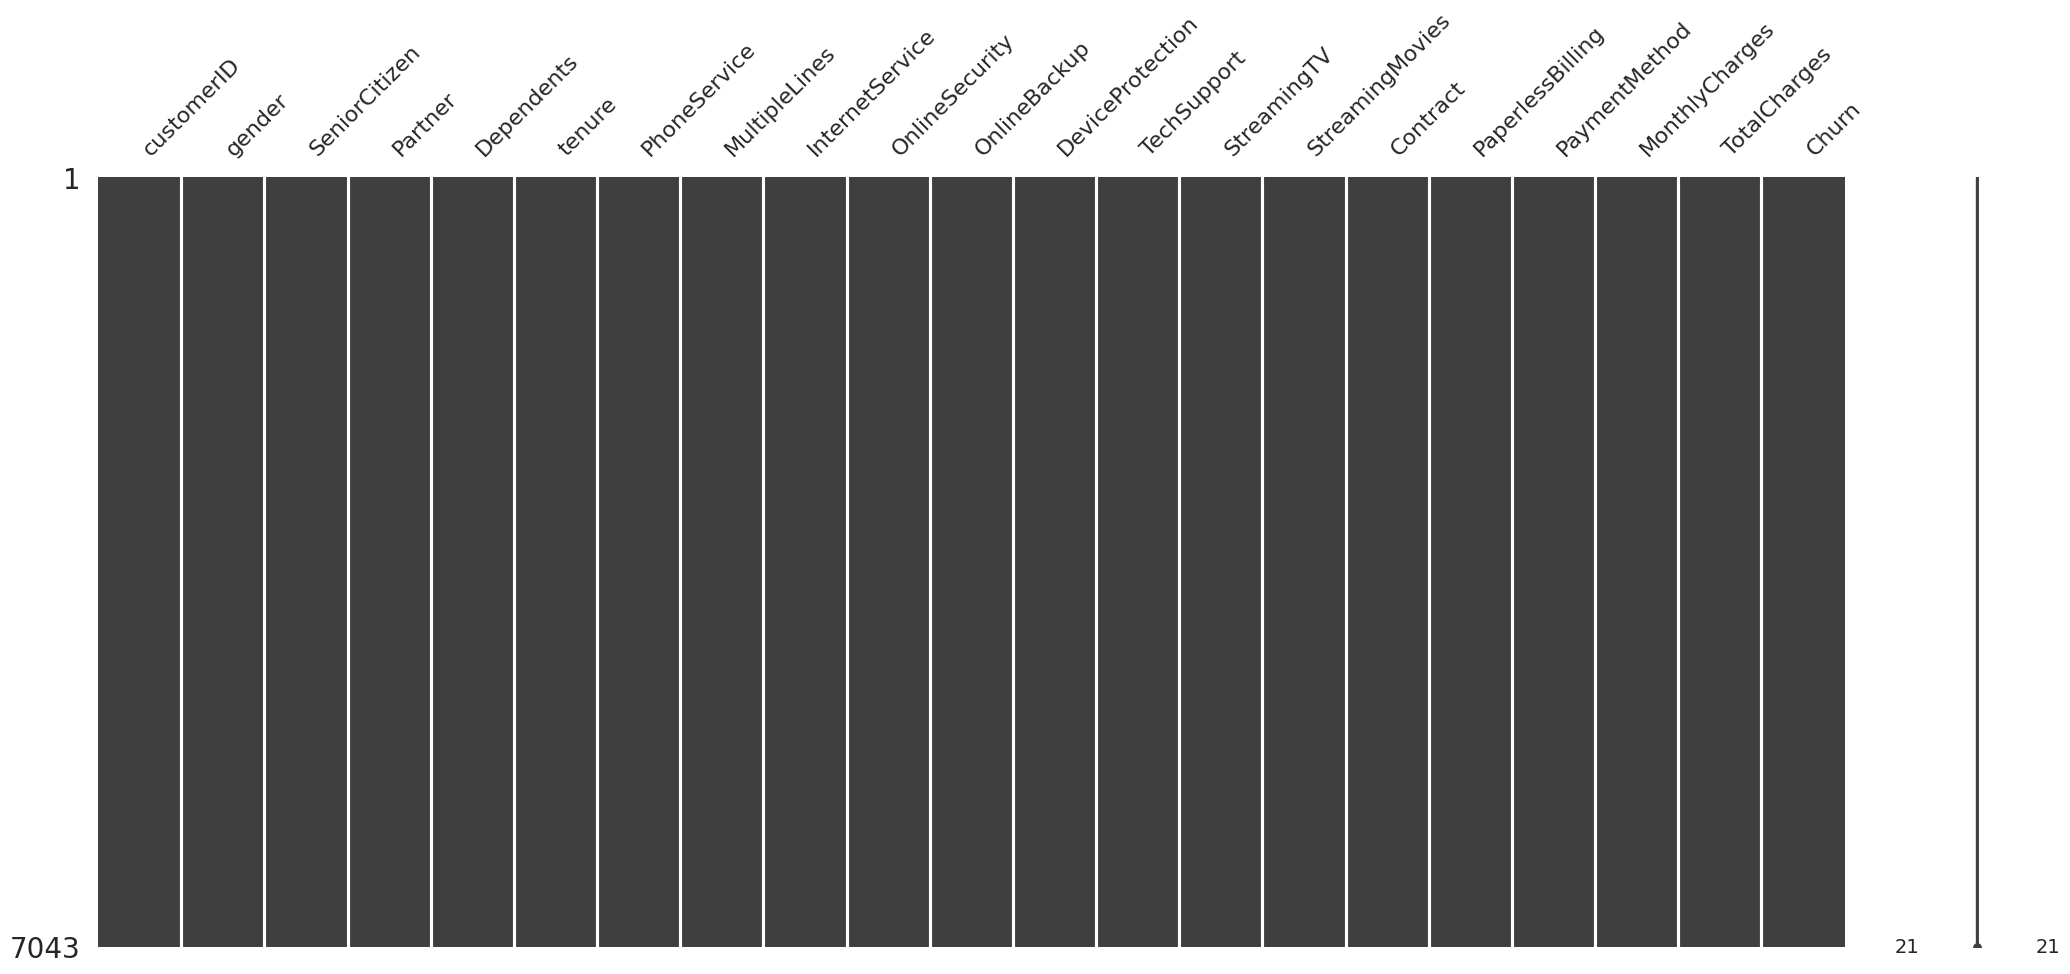

In [84]:
import missingno as msno
msno.matrix(customer_data)

As we can see, there are no blank spaces in the plot, indicating that there is no missing data.

**Data Cleaning**

Create a copy of base data for manipulation & processing

In [87]:
customer_data_copy = customer_data.copy()

Total Charges should be numeric amount. Convert it to numerical data type

In [88]:
customer_data_copy.TotalCharges = pd.to_numeric(customer_data_copy.TotalCharges, errors='coerce')
customer_data_copy.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


We can see that there are 11 missing values in the TotalCharges column.

In [89]:
customer_data_copy.loc[customer_data_copy['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [90]:
missing_percentage = customer_data_copy['TotalCharges'].isnull().mean() * 100
print(f"Percentage of missing data in TotalCharges column: {missing_percentage:.2f}%")

Percentage of missing data in TotalCharges column: 0.16%


Since the percentage of these records compared to the total dataset is very low, at just 0.16%, it is safe to exclude them from further processing.

In [91]:
customer_data_copy.dropna(how = 'any', inplace = True)

Divide customers into bins based on tenure, for example: assign a tenure group of 1-12 for customers with tenure less than 12 months, a tenure group of 13-24 for those with tenure between 1 and 2 years, and so on.

In [92]:
# Get the max tenure
print(customer_data_copy['tenure'].max()) #72

72


In [93]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

customer_data_copy['tenure_group'] = pd.cut(customer_data_copy.tenure, range(1, 80, 12), right=False, labels=labels)

Count the number of customers in each tenure group

In [94]:
customer_data_copy['tenure_group'].value_counts()

,count
tenure_group,
1 - 12,2175
61 - 72,1407
13 - 24,1024
25 - 36,832
49 - 60,832
37 - 48,762


Remove columns that are not needed for processing

In [95]:
#drop column customerID and tenure
customer_data_copy.drop(columns= ['customerID','tenure'], axis=1, inplace=True)
customer_data_copy.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


In [96]:
customer_data_copy.SeniorCitizen.unique()

array([0, 1])

Map the SeniorCitizen column values from 0/1 to 'No'/'Yes'

In [97]:
customer_data_copy.SeniorCitizen = customer_data_copy.SeniorCitizen.map({0: "No", 1: "Yes"})
customer_data_copy.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


**Data Exploration**

Plot the distribution of each predictor variable, segmented by churn status

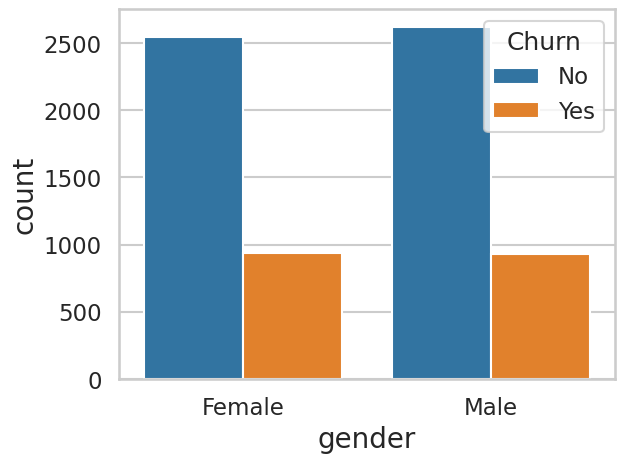

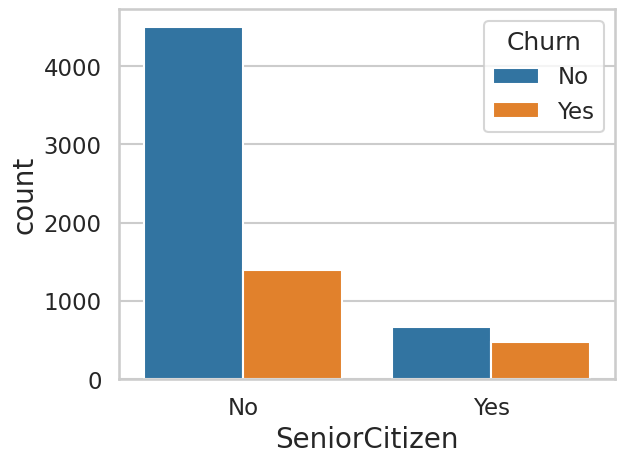

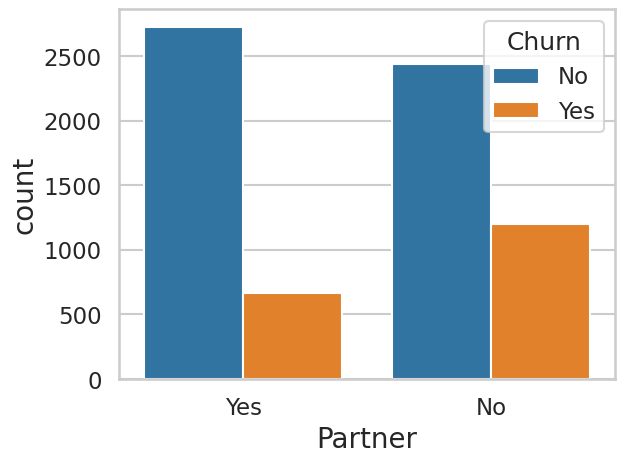

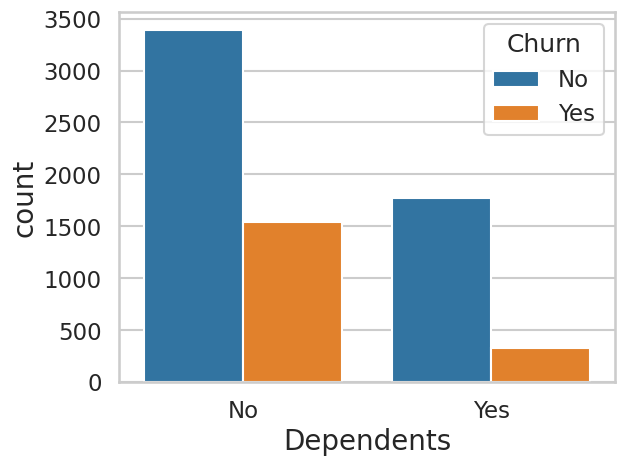

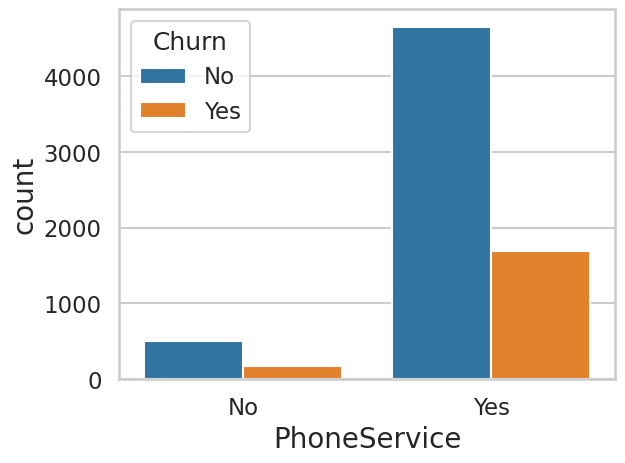

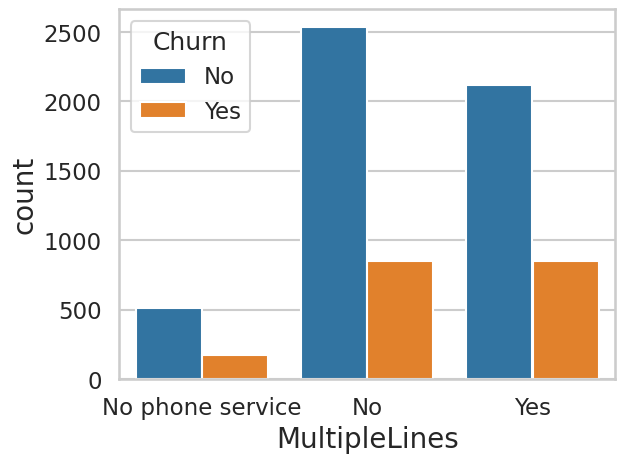

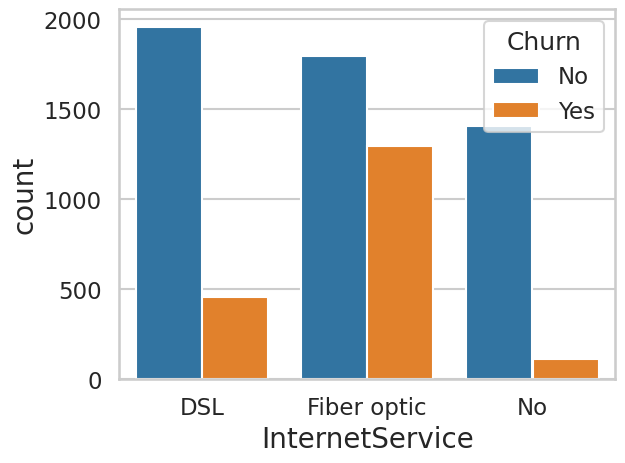

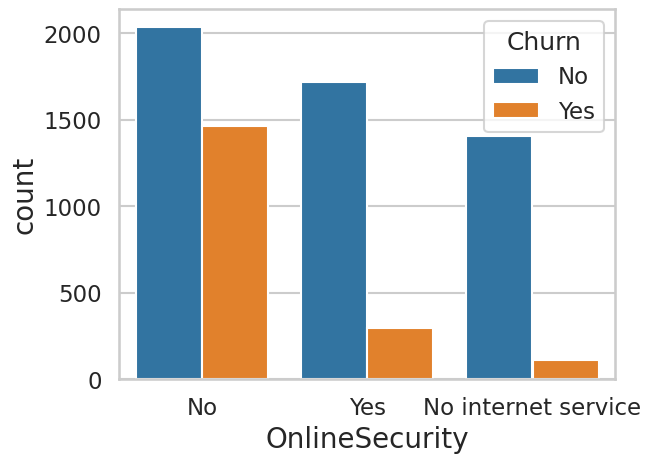

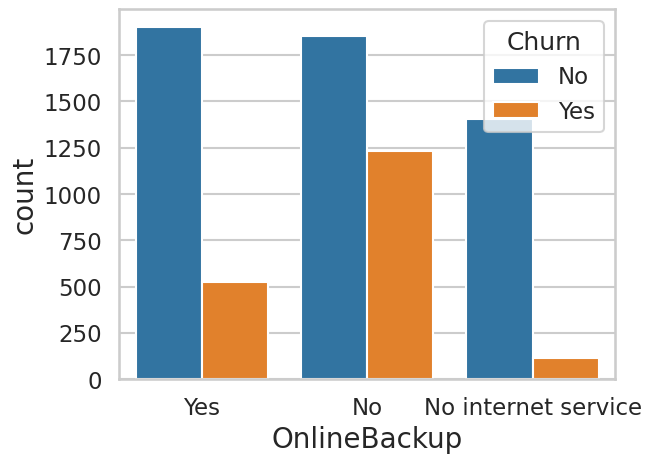

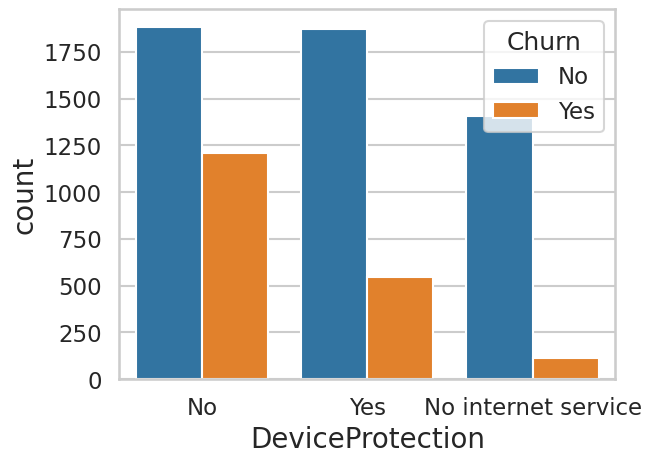

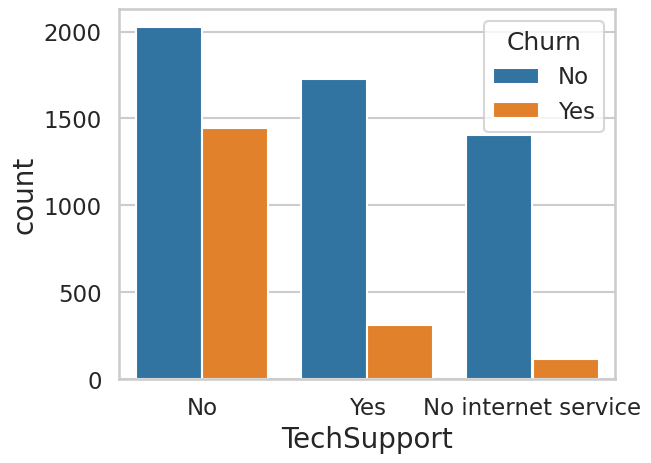

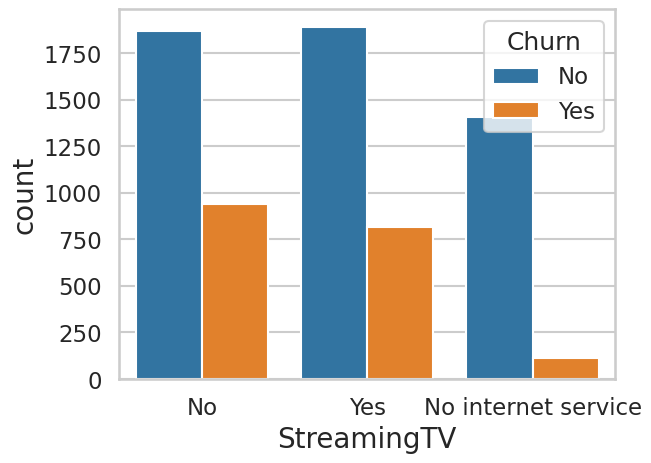

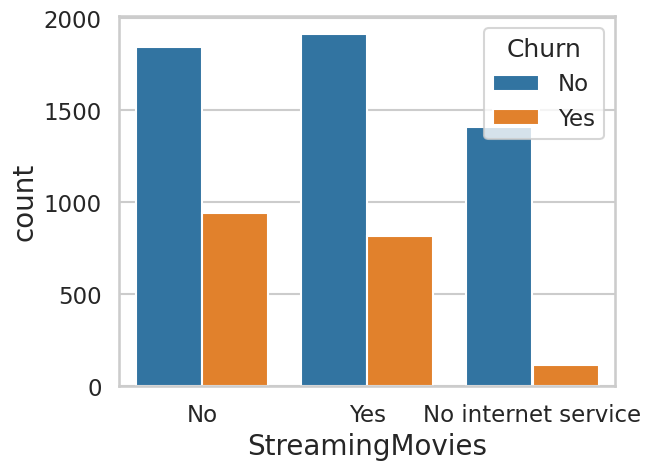

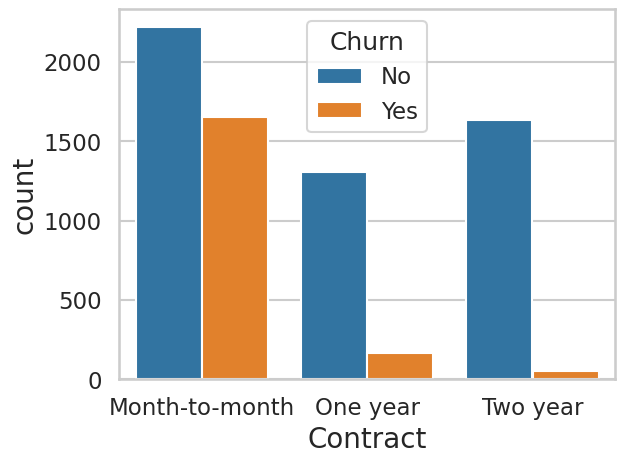

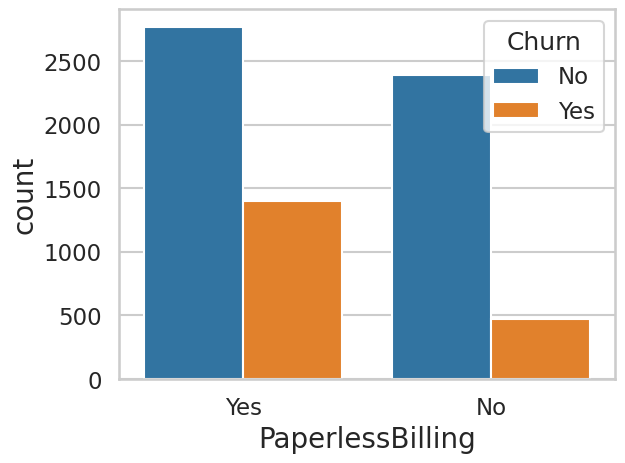

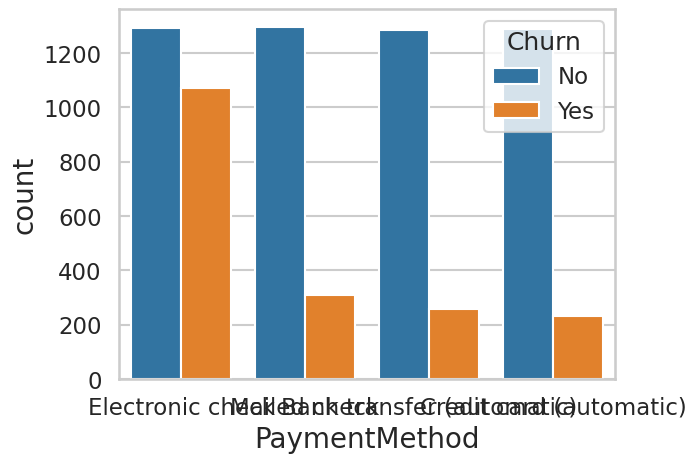

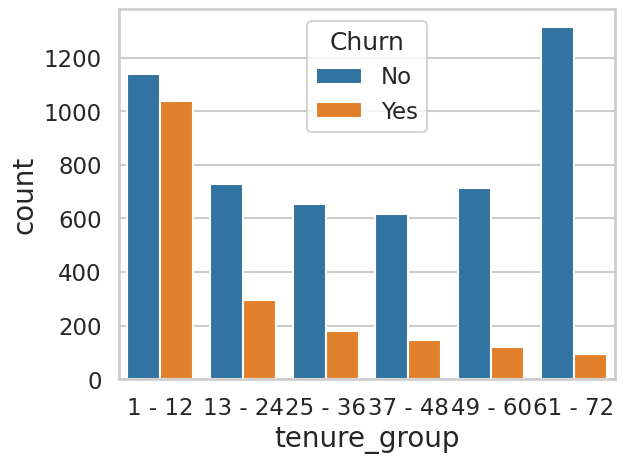

In [98]:
for i, predictor in enumerate(customer_data_copy.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=customer_data_copy, x=predictor, hue='Churn')

Convert the target variable 'Churn' to a binary numeric format, where 'Yes' is represented as 1 and 'No' is represented as 0

In [99]:
customer_data_copy['Churn'] = np.where(customer_data_copy.Churn == 'Yes',1,0)

In [100]:
customer_data_copy.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


Convert all the categorical variables to dummy variables

In [101]:
customer_data_dummies = pd.get_dummies(customer_data_copy)
customer_data_dummies = customer_data_dummies.astype(int)
customer_data_dummies.head()

,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,29,29,0,1,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,56,1889,0,0,1,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,53,108,1,0,1,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42,1840,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,70,151,1,1,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


Relationship between Monthly Charges and Total Charges

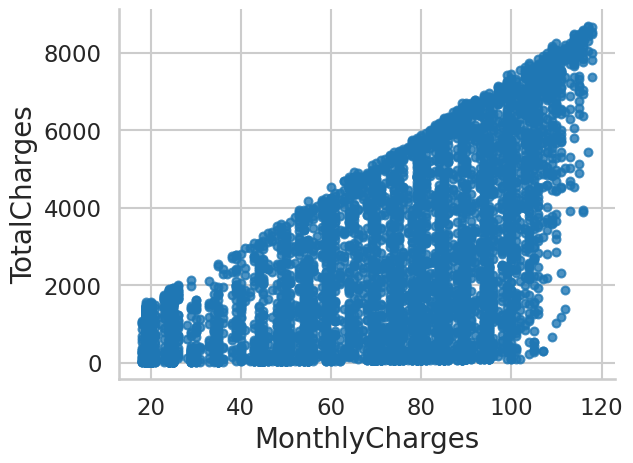

In [102]:
#MonthlyCharges vs TotalCharges
customer_data_dummies.plot(kind='scatter', x='MonthlyCharges', y='TotalCharges', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

As expected, Total Charges increase as Monthly Charges increase.

Churn rates in relation to Monthly Charges and Total Charges

Text(0.5, 1.0, 'Distribution of Monthly Charges by Churn Status')

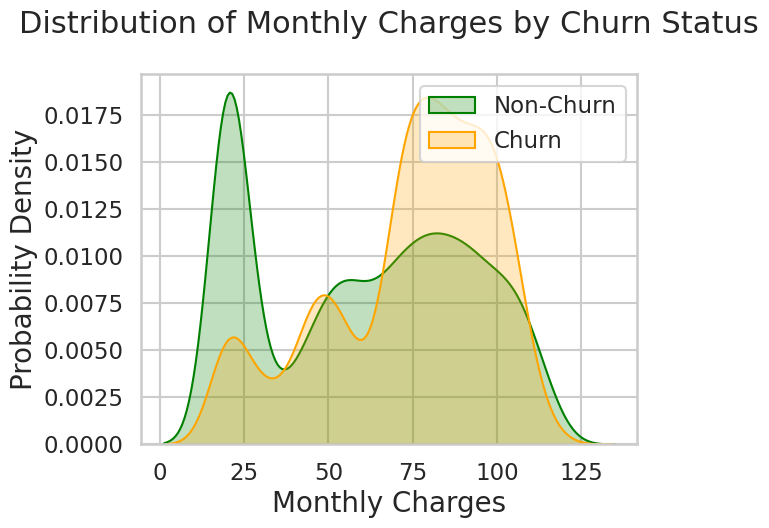

In [103]:
Mon = sns.kdeplot(customer_data_dummies.MonthlyCharges[customer_data_dummies["Churn"] == 0],
                             color="Green", fill=True)
Mon = sns.kdeplot(customer_data_dummies.MonthlyCharges[customer_data_dummies["Churn"] == 1],
                         ax=Mon, color="Orange", fill=True)
Mon.legend(["Non-Churn", "Churn"], loc='upper right')
Mon.set_ylabel('Probability Density')
Mon.set_xlabel('Monthly Charges')
Mon.set_title('Distribution of Monthly Charges by Churn Status')

Churn is higher when Monthly Charges are higher.

Text(0.5, 1.0, 'Distribution of Total Charges by Churn Status')

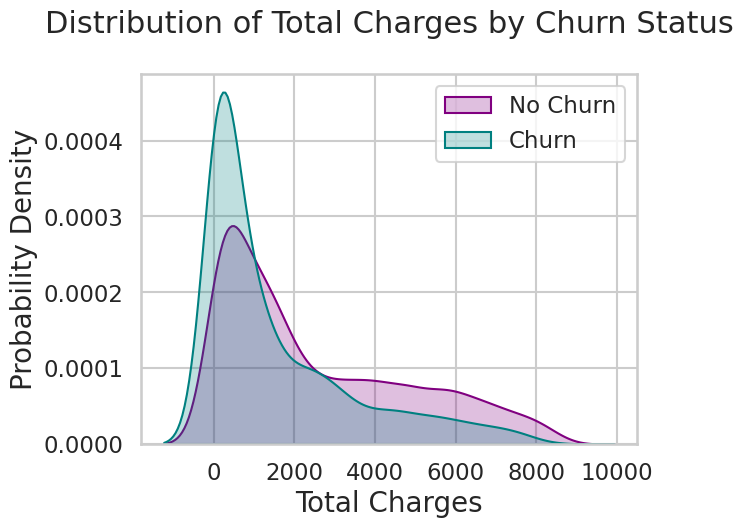

In [105]:
Tot = sns.kdeplot(customer_data_dummies.TotalCharges[customer_data_dummies["Churn"] == 0],
                  color="Purple", fill=True)
Tot = sns.kdeplot(customer_data_dummies.TotalCharges[customer_data_dummies["Churn"] == 1],
                  ax=Tot, color="Teal", fill=True)
Tot.legend(["No Churn", "Churn"], loc='upper right')
Tot.set_ylabel('Probability Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Distribution of Total Charges by Churn Status')

Higher churn is observed at lower Total Charges.

However, when considering all three factors—Tenure, Monthly Charges, and Total Charges—a clearer picture emerges:
*   Higher Monthly Charges with lower Tenure lead to lower Total Charges.
*   Thus, the combination of higher Monthly Charges, lower Tenure, and lower Total Charges is associated with higher Churn.

Calculate the correlation of all predictors with the 'Churn' variable

<Axes: >

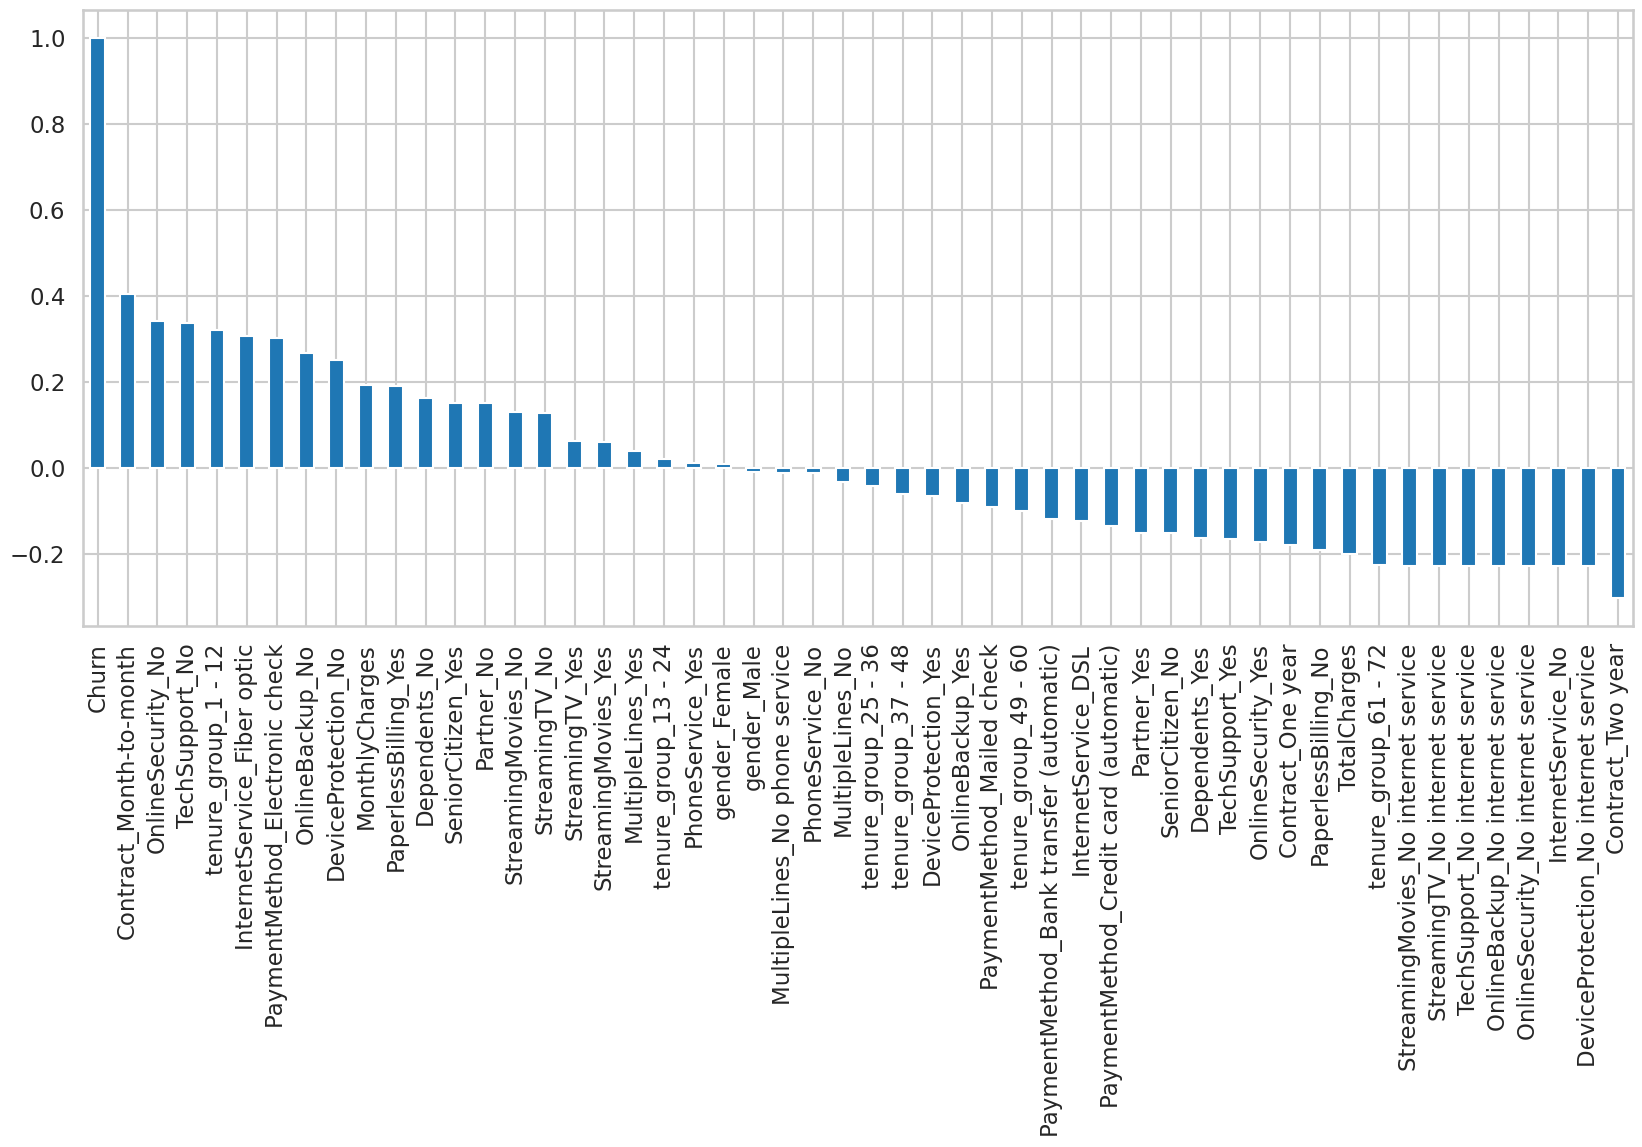

In [106]:
plt.figure(figsize=(20,8))
customer_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')



*   High churn is observed with month-to-month contracts, no online security, no tech support, during the first year of subscription, and with Fiber Optic internet.
*   Low churn is associated with long-term contracts, subscriptions without internet service, and customers engaged for 5+ years.


*   Factors such as Gender, availability of Phone Service, and the number of multiple lines have almost no impact on churn.







<Axes: >

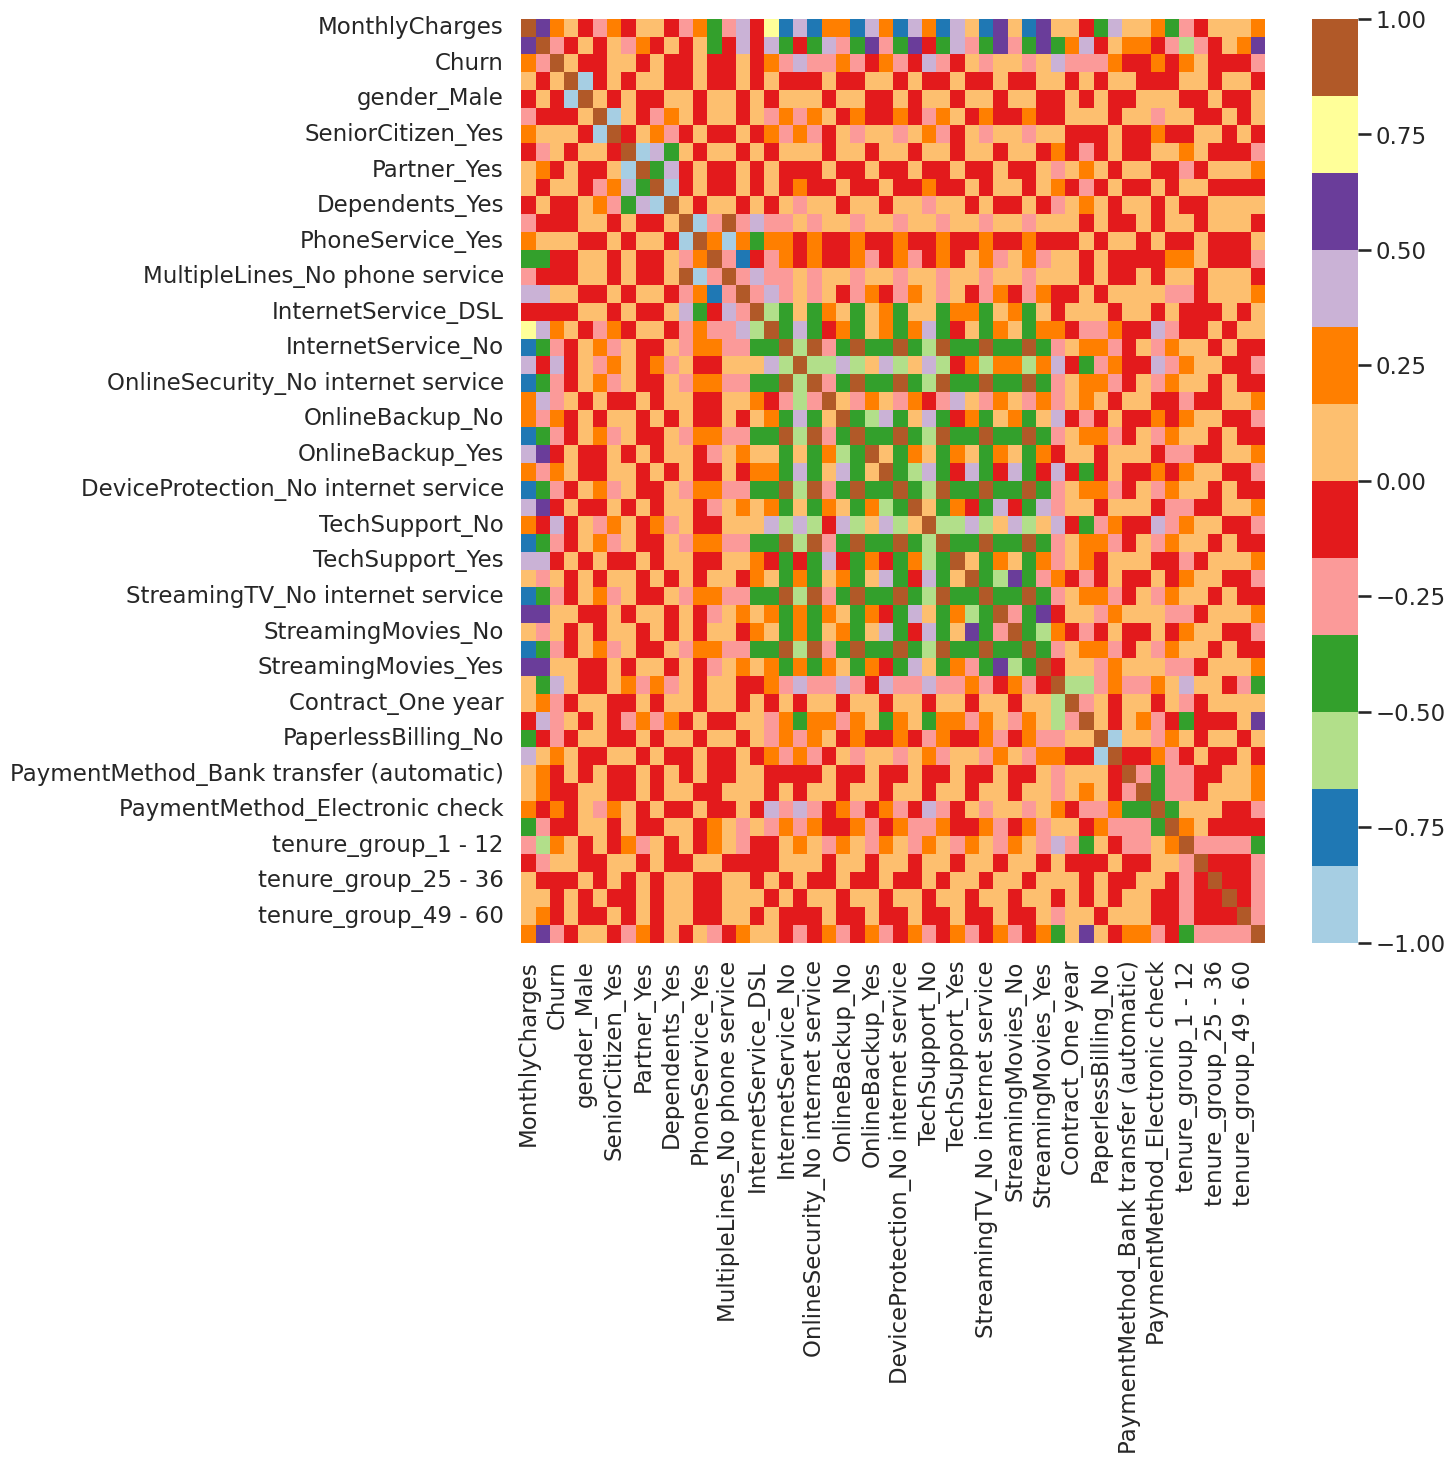

In [107]:
plt.figure(figsize=(12,12))
sns.heatmap(customer_data_dummies.corr(), cmap="Paired")

Bivariate Analysis

In [108]:
#Creating subsets of the data for customers with no churn and customers with churn
data_no_churn = customer_data_copy.loc[customer_data_copy["Churn"] == 0]
data_churn = customer_data_copy.loc[customer_data_copy["Churn"] == 1]

In [109]:
def plot_count_distribution(df, column, plot_title, hue=None):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30


    temp = pd.Series(data=hue)
    fig, ax = plt.subplots()
    width = len(df[column].unique()) + 7 + 4 * len(temp.unique())
    fig.set_size_inches(width , 8)

    plt.xticks(rotation=45)
    plt.title(plot_title)

    ax = sns.countplot(data=df, x=column, order=df[column].value_counts().index, hue=hue, palette='bright')

    plt.yscale('log')

    plt.show()

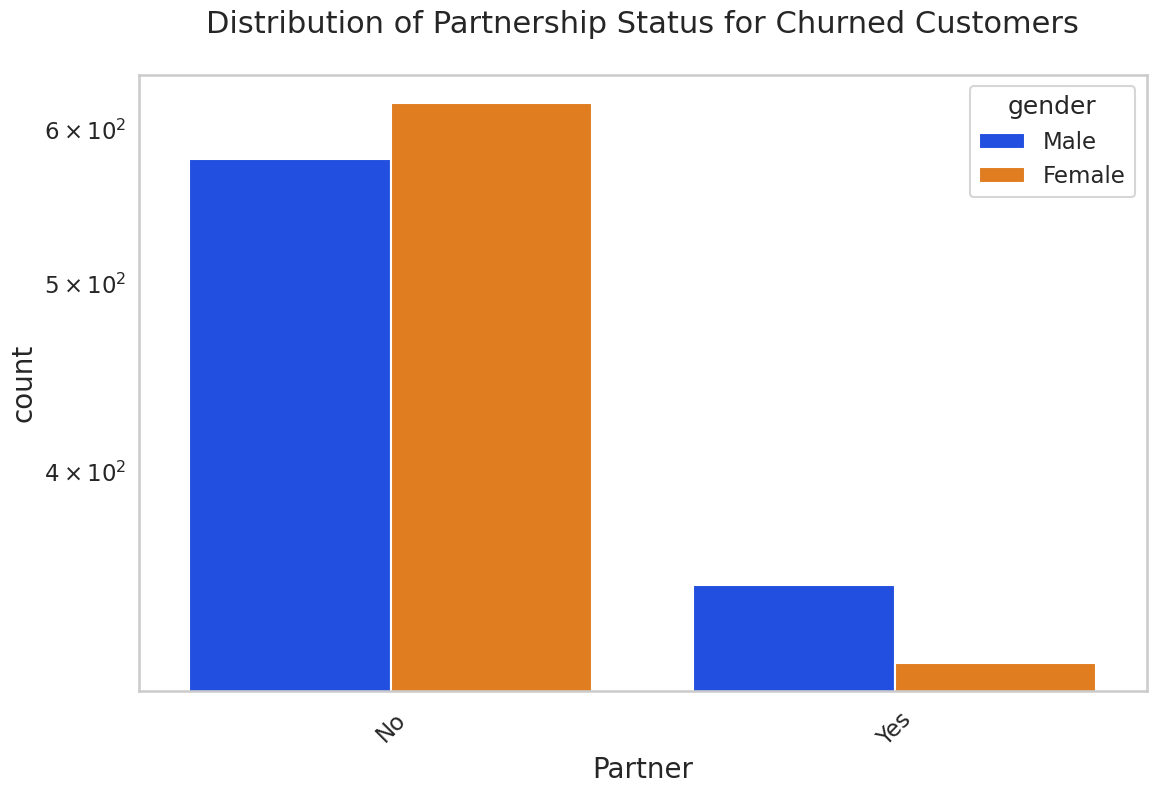

In [110]:
plot_count_distribution(data_churn, column='Partner', plot_title='Distribution of Partnership Status for Churned Customers', hue='gender')

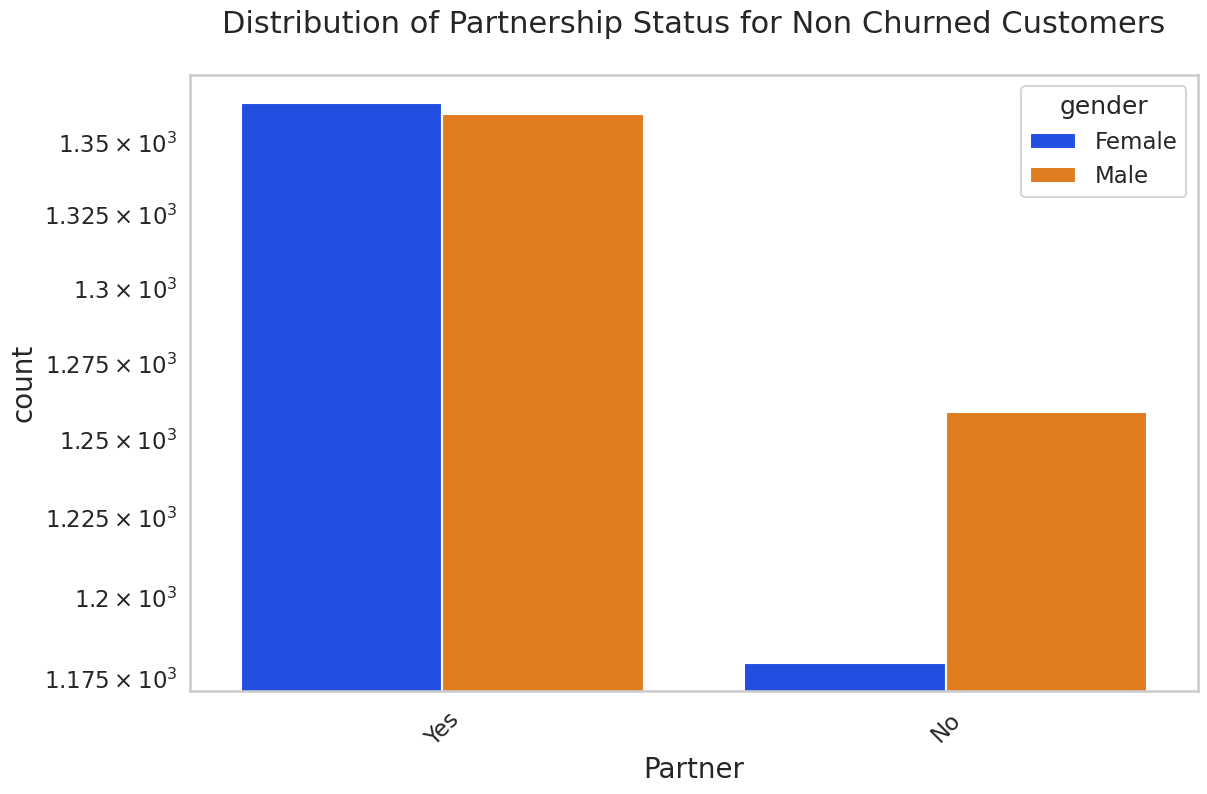

In [111]:
plot_count_distribution(data_no_churn, column='Partner', plot_title='Distribution of Partnership Status for Non Churned Customers', hue='gender')

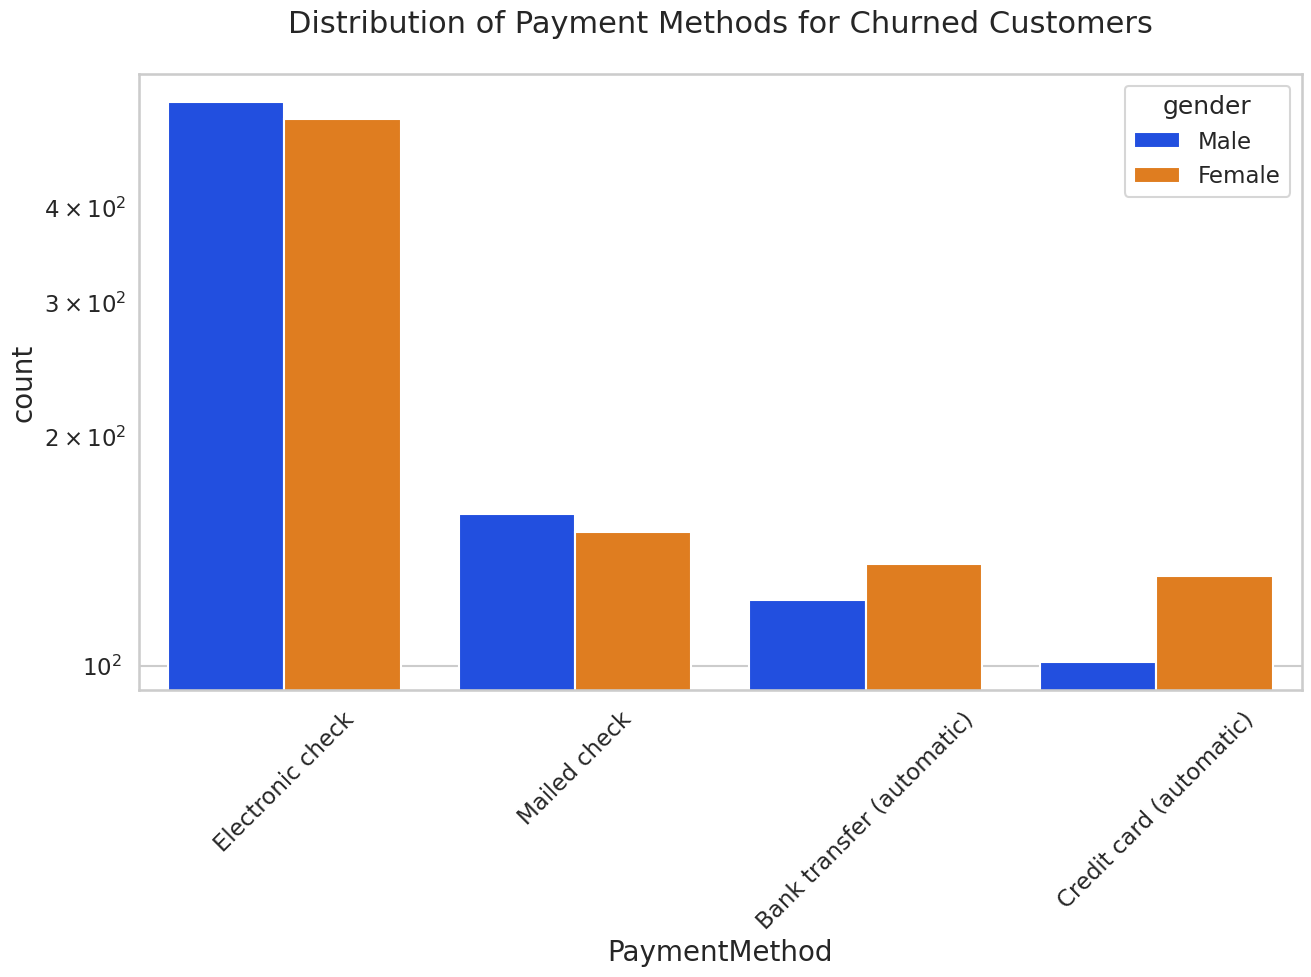

In [112]:
plot_count_distribution(data_churn, column='PaymentMethod', plot_title='Distribution of Payment Methods for Churned Customers', hue='gender')

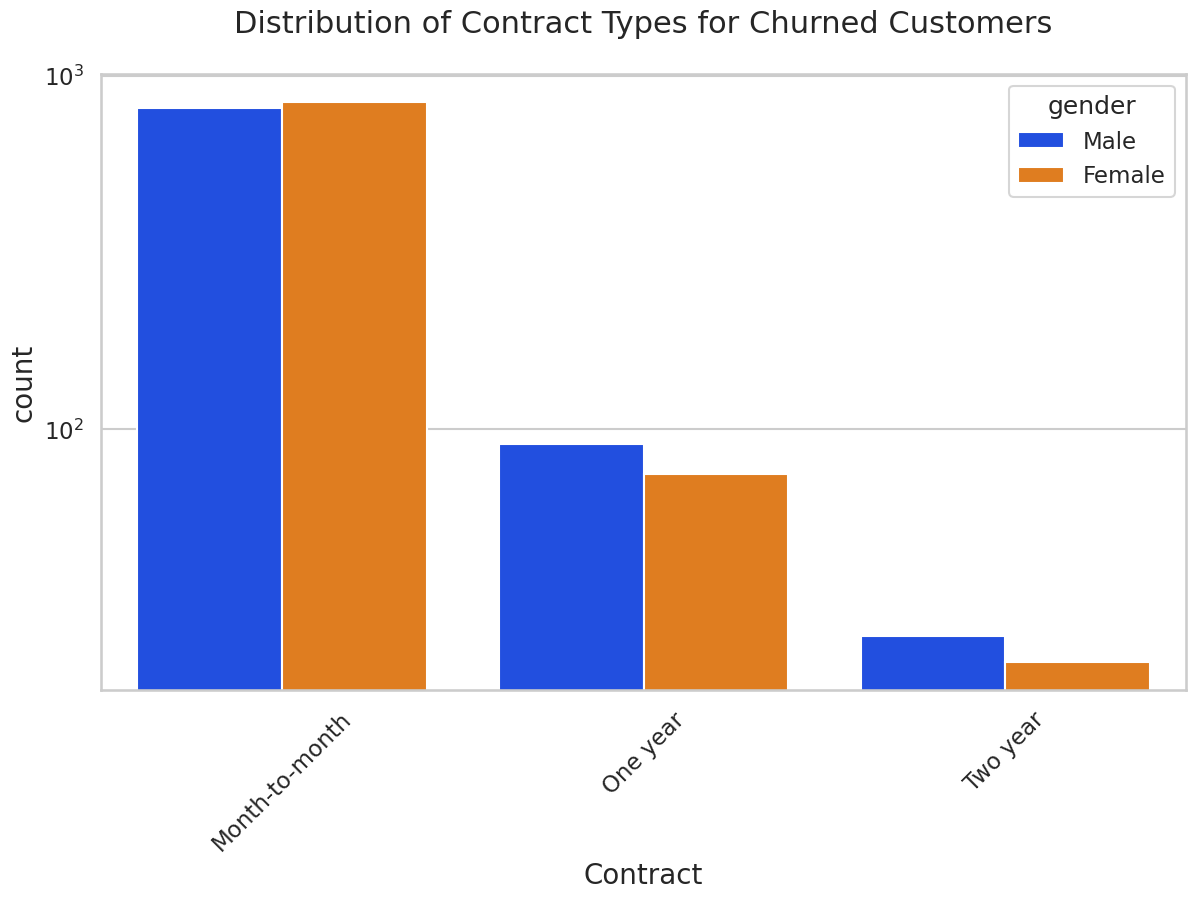

In [113]:
plot_count_distribution(data_churn, column='Contract', plot_title='Distribution of Contract Types for Churned Customers', hue='gender')

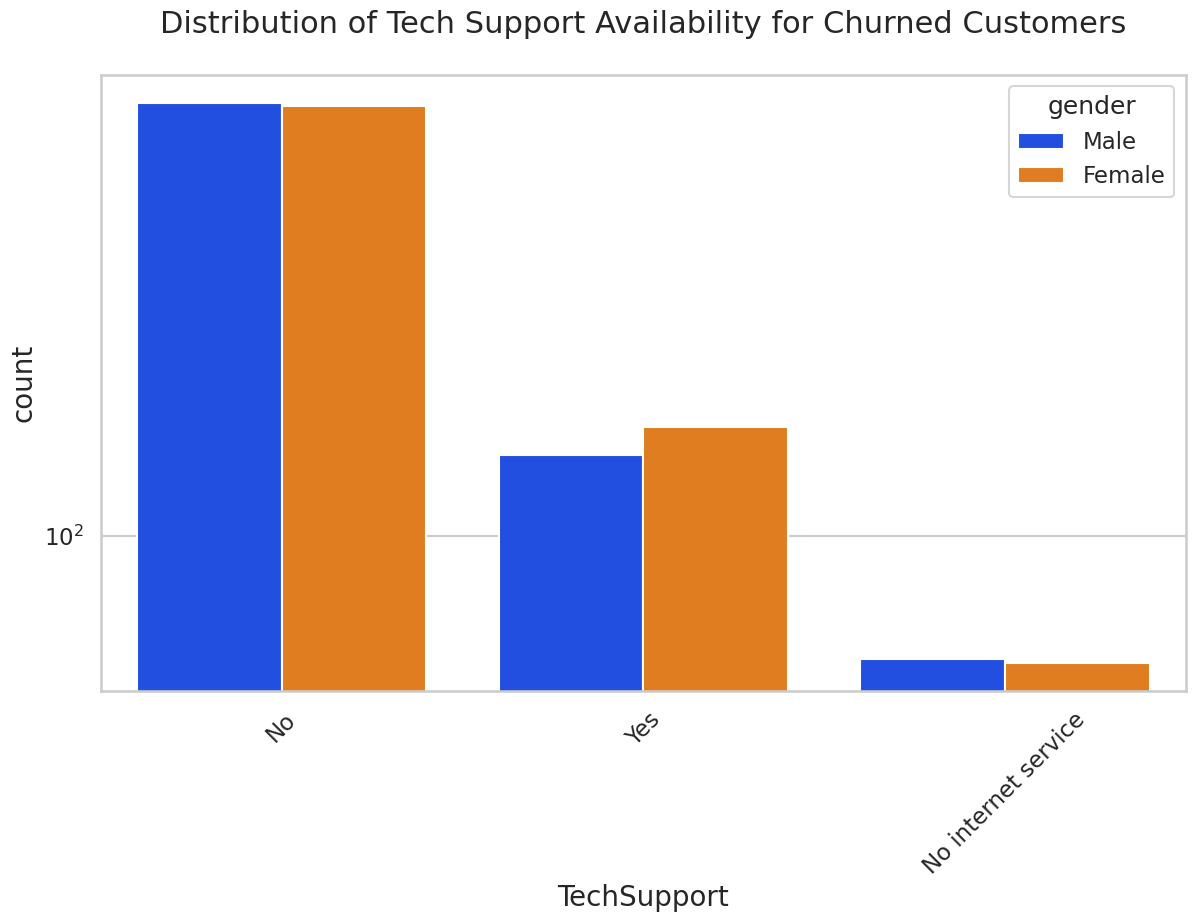

In [114]:
plot_count_distribution(data_churn, column='TechSupport', plot_title='Distribution of Tech Support Availability for Churned Customers', hue='gender')

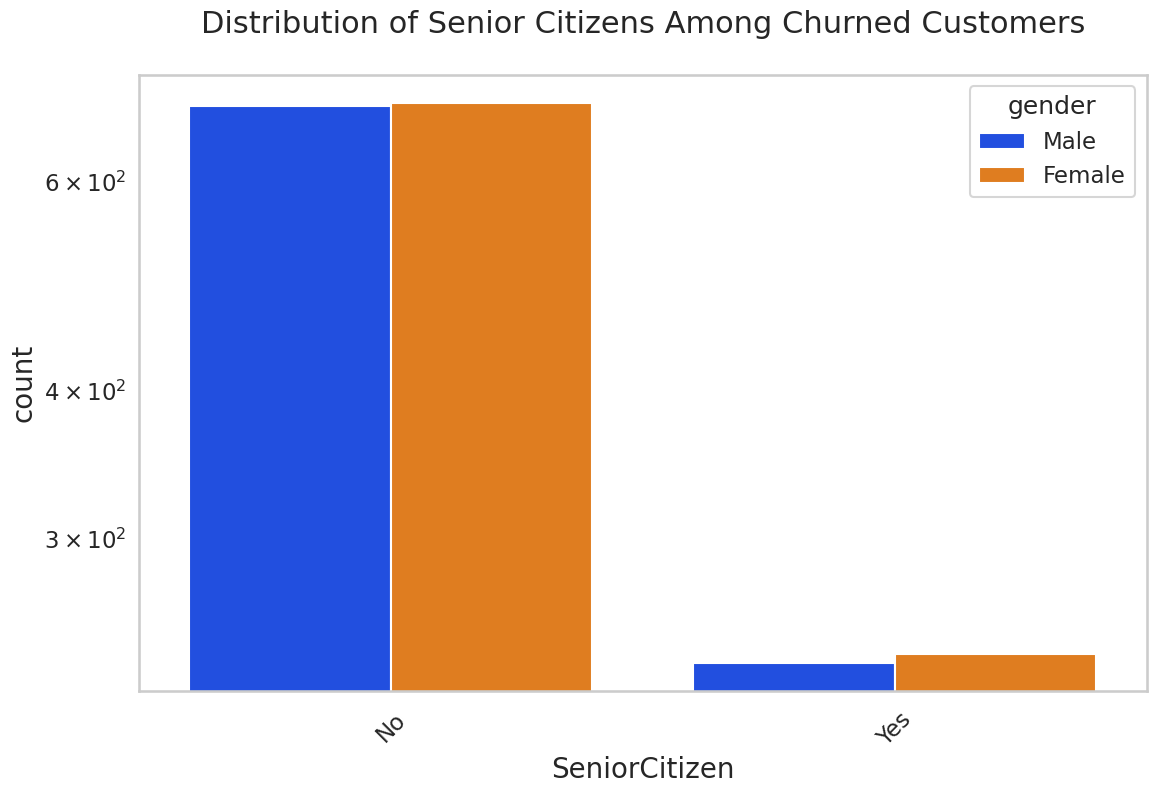

In [115]:
plot_count_distribution(data_churn, column='SeniorCitizen', plot_title='Distribution of Senior Citizens Among Churned Customers', hue='gender')

Some major insights:-

*   Customers who use electronic checks are the most likely to churn.
*   Monthly contract customers have a higher likelihood of churning due to the flexibility of no long-term commitments.


*   Customers without online security or tech support are among the highest churners.
*   Non-senior citizens exhibit a higher churn rate compared to senior citizens.




In [116]:
customer_data_dummies.to_csv('customer_churn.csv', index=False)

**Model Building**

In [118]:
df = pd.read_csv('customer_churn.csv')
df.head()

,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,29,29,0,1,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,56,1889,0,0,1,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,53,108,1,0,1,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42,1840,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,70,151,1,1,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


Creating X and Y variables

In [119]:
x=df.drop('Churn',axis=1)
x

,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,29,29,1,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,56,1889,0,1,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,53,108,0,1,1,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,42,1840,0,1,1,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,70,151,1,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84,1990,0,1,1,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
7028,103,7362,1,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
7029,29,346,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
7030,74,306,0,1,0,1,0,1,1,0,...,0,0,0,1,1,0,0,0,0,0


In [120]:
y=df['Churn']
y

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7027,0
7028,0
7029,0
7030,1


Train Test Split

In [124]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

Decision Tree Classifier

In [125]:
dt_model=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [126]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [127]:
y_pred=dt_model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [128]:
dt_model.score(X_test,y_test)

0.8024164889836531

In [129]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1042
           1       0.66      0.48      0.56       365

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



Since the accuracy is quite low, and given that this is an imbalanced dataset, accuracy is not a reliable metric to evaluate the model's performance. Accuracy can be misleading in imbalanced datasets, so we should focus on metrics like recall, precision, and F1 score, particularly for the minority class. It's clear that the precision, recall, and F1 score for Class 1 (churned customers) are too low.

Therefore, we will proceed to apply SMOTEENN (a combination of upsampling and ENN) to address the imbalance.

In [130]:
#Applying SMOTEENN to balance the dataset
smote_enn = SMOTEENN()
X_balanced, y_balanced = smote_enn.fit_resample(x, y)

#Splitting the resampled data into training and testing sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2)

In [131]:
dt_model_smote=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [132]:
dt_model_smote.fit(X_train_bal,y_train_bal)
y_predict_bal = dt_model_smote.predict(X_test_bal)
dt_model_score_bal = dt_model_smote.score(X_test_bal, y_test_bal)
print(dt_model_score_bal)
print(metrics.classification_report(y_test_bal, y_predict_bal))

0.939419795221843
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       533
           1       0.92      0.97      0.95       639

    accuracy                           0.94      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.94      0.94      0.94      1172



In [133]:
print(metrics.confusion_matrix(y_test_bal, y_predict_bal))

[[478  55]
 [ 16 623]]


Now, we can see significantly improved results, with an accuracy of 92%, as well as strong recall, precision, and F1 scores for the minority class. Let's try using a different classifier to see if we can achieve even better performance.

In [134]:
rf_model_smote=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [135]:
rf_model_smote.fit(X_train_bal,y_train_bal)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [136]:
y_pred_rf = rf_model_smote.predict(X_test_bal)

In [137]:
rf_model_score_bal = rf_model_smote.score(X_test_bal, y_test_bal)

In [138]:
print(rf_model_score_bal)
print(metrics.classification_report(y_test_bal, y_predict_bal))

0.9402730375426621
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       533
           1       0.92      0.97      0.95       639

    accuracy                           0.94      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.94      0.94      0.94      1172



In [139]:
print(metrics.confusion_matrix(y_test_bal, y_predict_bal))

[[478  55]
 [ 16 623]]


With the Random Forest classifier, we're also achieving strong results—better, in fact, than those obtained with the Decision Tree.

In [140]:
pca = PCA(0.9)
X_train_pca_bal = pca.fit_transform(X_train_bal)
X_test_pca_bal = pca.transform(X_test_bal)
explained_var = pca.explained_variance_ratio_

In [141]:
model=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [142]:
model.fit(X_train_pca_bal,y_train_bal)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [143]:
y_predict_pca_bal = model.predict(X_test_pca_bal)

In [144]:
pca_model_score_bal = model.score(X_test_pca_bal, y_test_bal)

In [145]:
print(pca_model_score_bal)
print(metrics.classification_report(y_test_bal, y_predict_pca_bal))

0.7201365187713311
              precision    recall  f1-score   support

           0       0.71      0.64      0.68       533
           1       0.72      0.79      0.75       639

    accuracy                           0.72      1172
   macro avg       0.72      0.71      0.71      1172
weighted avg       0.72      0.72      0.72      1172



With PCA, we didn’t see any improvement in the results. Therefore, let's finalize the model created using the Random Forest classifier.